In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf ## auto correlation
from statsmodels.graphics.tsaplots import plot_pacf ## partial auto-correlation

from statsmodels.tsa.api import VAR

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path_to_file = '/content/drive/My Drive/Colab Notebooks/Cave_Data/'

data_csv1 = pd.read_csv(path_to_file + 'OxygenandTemp1.csv', sep=',', parse_dates=[['Date', 'Time']])
data_csv1.head(3)

,Date_Time,DO (mg/L),Temp (°C)
0,2017-04-24 15:00:00,17.61,10.94
1,2017-04-24 15:15:00,17.53,10.94
2,2017-04-24 15:30:00,17.60,10.96


In [4]:
print ('max & min of date:', data_csv1['Date_Time'].max(), data_csv1['Date_Time'].min())
print ('max & min of oxygen: ', data_csv1['DO (mg/L)'].max(), data_csv1['DO (mg/L)'].min(), data_csv1['DO (mg/L)'].mean())
print ('max & min of Temp: ', data_csv1['Temp (°C)'].max(), data_csv1['Temp (°C)'].min())

print ('how many zeros in oxygen: ', (data_csv1['DO (mg/L)'] == 0.0).sum())

cave_data1 = data_csv1.rename({'Date_Time': 'datetime' ,'DO (mg/L)': 'Oxygen', 'Temp (°C)': 'Temp'}, axis=1)

cave_data1['datetime'] = pd.to_datetime(cave_data1['datetime'])
cave_data1 = cave_data1.set_index('datetime') 

print(cave_data1.head(5))
print ('\n')
print ('cave data shape: ', cave_data1.shape)

max & min of date: 2017-11-23 10:15:00 2017-04-24 15:00:00
max & min of oxygen:  17.67 0.0 7.567484581497799
max & min of Temp:  28.88 4.9
how many zeros in oxygen:  3
                     Oxygen   Temp
datetime                          
2017-04-24 15:00:00   17.61  10.94
2017-04-24 15:15:00   17.53  10.94
2017-04-24 15:30:00   17.60  10.96
2017-04-24 15:45:00   17.66  10.98
2017-04-24 16:00:00   17.67  11.00


cave data shape:  (20430, 2)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f49e0e38f50>,
      dtype=object)

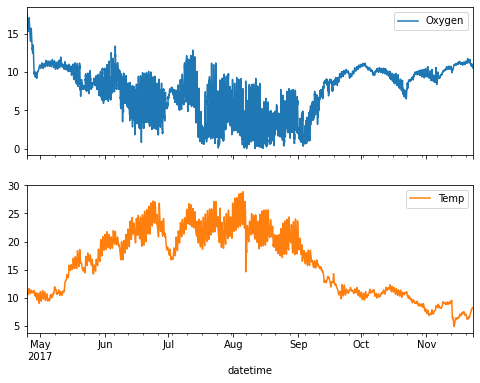

In [ ]:
cave_data1.plot(subplots=True, figsize=(8,6))

select dataframe shape:  (14593, 2)


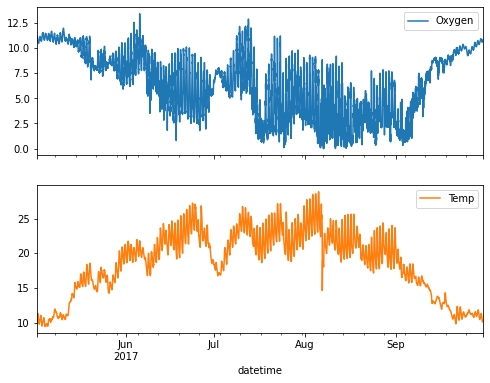

In [5]:
### select  a subset of the data-frame 

cave_data1_may_sept = cave_data1["2017-05-01 15:00:00": "2017-09-30 15:00:00"]
print ('select dataframe shape: ', cave_data1_may_sept.shape)

fig, ax = cave_data1_may_sept.plot(subplots=True, figsize=(8, 6))

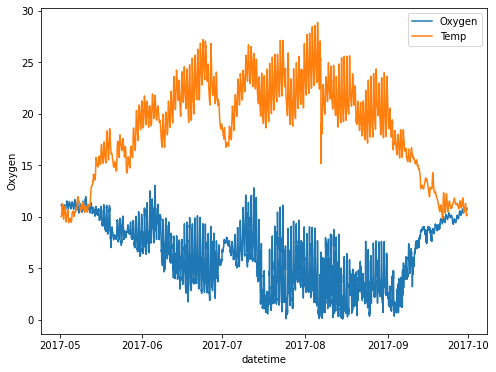

total samples of daily data:  7297


In [6]:
resampled_oxygen1_30Minutes = cave_data1_may_sept["Oxygen"].resample("30T").mean() # 
resampled_temp1_30Minutes = cave_data1_may_sept["Temp"].resample("30T").mean() # 30 minutes

fig = plt.figure(figsize=(8, 6))
sns.lineplot(data = resampled_oxygen1_30Minutes, label='Oxygen')
sns.lineplot(data = resampled_temp1_30Minutes, label='Temp')
plt.show()

print ('total samples of daily data: ', len(resampled_oxygen1_30Minutes))

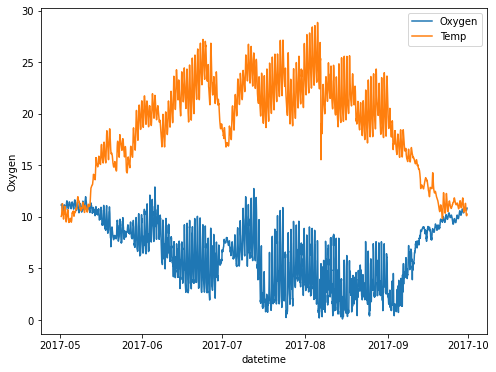

total samples of daily data:  3649


In [7]:
resampled_oxygen1_h = cave_data1_may_sept["Oxygen"].resample("60T").mean() # hourly samples
resampled_temp1_h = cave_data1_may_sept["Temp"].resample("60T").mean() # hourly samples

fig = plt.figure(figsize=(8, 6))
sns.lineplot(data = resampled_oxygen1_h, label='Oxygen')
sns.lineplot(data = resampled_temp1_h, label='Temp')
plt.show()

print ('total samples of daily data: ', len(resampled_oxygen1_h))

### Checking if Data is Stationary

1. Check the Rolling Mean and Std. 
2. Check with ADCF test (Augmented Dickey-Fuller Test). 
3. We can also check KPSS test. 


### If the Data is Not Stationary

1. Try several schemes, best option is differencing. 

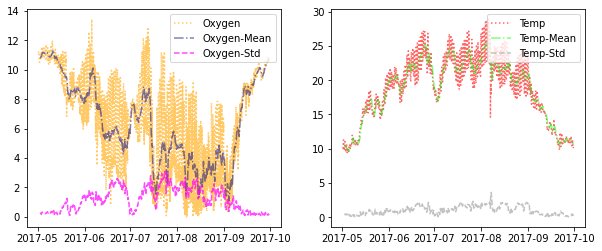

In [8]:
simple_oxygen_mean_may_sept = cave_data1_may_sept['Oxygen'].rolling(window=96).mean()
simple_temp_mean_may_sept = cave_data1_may_sept['Temp'].rolling(window=96).mean()

simple_std_oxygen_may_sept = cave_data1_may_sept['Oxygen'].rolling(window=96).std()
simple_std_temp_may_sept = cave_data1_may_sept['Temp'].rolling(window=96).std()

fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.plot(cave_data1_may_sept['Oxygen'], color='orange', linestyle=':', alpha=0.6, label='Oxygen')
plt.plot(simple_oxygen_mean_may_sept, color='navy', linestyle='-.', alpha=0.5, label='Oxygen-Mean')
plt.plot(simple_std_oxygen_may_sept, color='magenta', linestyle='--', alpha=0.7, label='Oxygen-Std')
plt.legend(fontsize=10, loc=1)
fig.add_subplot(122)
plt.plot(cave_data1_may_sept['Temp'], color='red', linestyle=':', alpha=0.6, label='Temp')
plt.plot(simple_temp_mean_may_sept, color='lime', linestyle='-.', alpha=0.5, label='Temp-Mean')
plt.plot(simple_std_temp_may_sept, color='darkgray', linestyle='--', alpha=0.7, label='Temp-Std')
plt.legend(fontsize=10, loc=1)
plt.show()

even though the rolling mean curve is not exactly parallel to X-axis, tje standard deviation (daily) curve seems almost parallel to x-axis. This is a possible indication that the time series is possibly stable with time. We will check this with the ACDF test. 

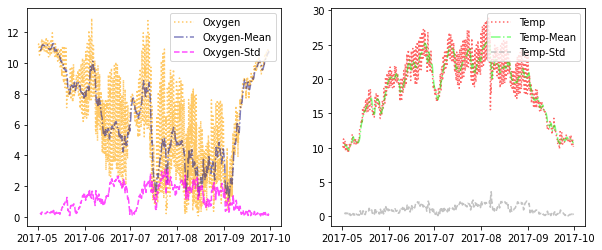

check the lens before and after rolling mean:  3649 3649 nan 0.0925 23 [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]]


In [9]:
simple_oxygen_mean_may_sept_h = resampled_oxygen1_h.rolling(window=24).mean()
simple_temp_mean_may_sept_h = resampled_temp1_h.rolling(window=24).mean()

simple_std_oxygen_may_sept_h = resampled_oxygen1_h.rolling(window=24).std()
simple_std_temp_may_sept_h = resampled_temp1_h.rolling(window=24).std()

fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.plot(resampled_oxygen1_h, color='orange', linestyle=':', alpha=0.6, label='Oxygen')
plt.plot(simple_oxygen_mean_may_sept_h, color='navy', linestyle='-.', alpha=0.5, label='Oxygen-Mean')
plt.plot(simple_std_oxygen_may_sept_h, color='magenta', linestyle='--', alpha=0.7, label='Oxygen-Std')
plt.legend(fontsize=10, loc=1)

fig.add_subplot(122)
plt.plot(resampled_temp1_h, color='red', linestyle=':', alpha=0.6, label='Temp')
plt.plot(simple_temp_mean_may_sept_h, color='lime', linestyle='-.', alpha=0.5, label='Temp-Mean')
plt.plot(simple_std_temp_may_sept_h, color='darkgray', linestyle='--', alpha=0.7, label='Temp-Std')
plt.legend(fontsize=10, loc=1)
plt.show()

simple_oxygen_mean_may_sept_h_arr = simple_oxygen_mean_may_sept_h.to_numpy()
simple_temp_mean_may_sept_h_arr = simple_temp_mean_may_sept_h.to_numpy()

print ('check the lens before and after rolling mean: ', len(simple_oxygen_mean_may_sept_h), len(resampled_oxygen1_h), min(simple_oxygen_mean_may_sept_h), min(resampled_oxygen1_h), 
       np.isnan(simple_oxygen_mean_may_sept_h).sum(), np.argwhere(np.isnan(simple_oxygen_mean_may_sept_h_arr) ) ) 

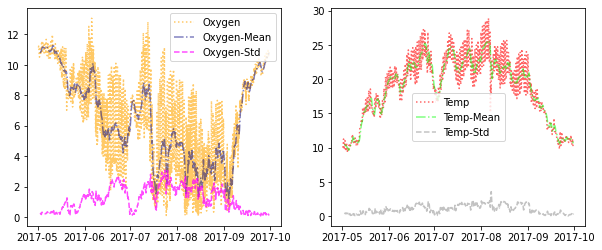

check the lens before and after rolling mean:  7297 7297 nan 0.085 47 [[0]
 [1]
 [2]
 [3]
 [4]]


In [10]:
simple_oxygen_mean_may_sept_30min = resampled_oxygen1_30Minutes.rolling(window=48).mean()
simple_temp_mean_may_sept_30min = resampled_temp1_30Minutes.rolling(window=48).mean()

simple_std_oxygen_may_sept_30min = resampled_oxygen1_30Minutes.rolling(window=48).std()
simple_std_temp_may_sept_30min = resampled_temp1_30Minutes.rolling(window=48).std()

fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.plot(resampled_oxygen1_30Minutes, color='orange', linestyle=':', alpha=0.6, label='Oxygen')
plt.plot(simple_oxygen_mean_may_sept_30min, color='navy', linestyle='-.', alpha=0.5, label='Oxygen-Mean')
plt.plot(simple_std_oxygen_may_sept_30min, color='magenta', linestyle='--', alpha=0.7, label='Oxygen-Std')
plt.legend(fontsize=10, loc=1)

fig.add_subplot(122)
plt.plot(resampled_temp1_30Minutes, color='red', linestyle=':', alpha=0.6, label='Temp')
plt.plot(simple_temp_mean_may_sept_30min, color='lime', linestyle='-.', alpha=0.5, label='Temp-Mean')
plt.plot(simple_std_temp_may_sept_30min, color='darkgray', linestyle='--', alpha=0.7, label='Temp-Std')
plt.legend(fontsize=10, )
plt.show()

simple_oxygen_mean_may_sept_30min_arr = simple_oxygen_mean_may_sept_30min.to_numpy()
simple_temp_mean_may_sept_30min_arr = simple_temp_mean_may_sept_30min.to_numpy()

print ('check the lens before and after rolling mean: ', len(simple_oxygen_mean_may_sept_30min), len(resampled_oxygen1_30Minutes), min(simple_oxygen_mean_may_sept_30min), min(resampled_oxygen1_30Minutes), 
       np.isnan(simple_oxygen_mean_may_sept_30min).sum(), np.argwhere(np.isnan(simple_oxygen_mean_may_sept_30min_arr)[:5] ) )

In [11]:
from statsmodels.tsa.stattools import adfuller

# cave_data_testADF_log = adfuller(np.log10(cave_data1_may_sept['Oxygen'], out=np.zeros_like(cave_data1_may_sept['Oxygen']), 
#                                       where=(cave_data1_may_sept['Oxygen']!=0.0)), )

cave_data_testADF = adfuller(cave_data1_may_sept['Oxygen'], )
cave_data_testADF_Temp = adfuller(cave_data1_may_sept['Temp'], )

#np.log2(m, out=np.zeros_like(m), where=(m!=0))

cavedfoutput_ADF = pd.Series(cave_data_testADF[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
cavedfoutput_ADF_T = pd.Series(cave_data_testADF_Temp[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print('for O2')
for key,value in cave_data_testADF[4].items():
    cavedfoutput_ADF['Critical Value (%s)'%key] = value
    
print(cavedfoutput_ADF)

print('\n')
print('for temp')
for key,value in cave_data_testADF_Temp[4].items():
    cavedfoutput_ADF_T['Critical Value (%s)'%key] = value

print(cavedfoutput_ADF_T)    

for O2
Test Statistic                -6.263090e+00
p-value                        4.176921e-08
#Lags Used                     4.200000e+01
Number of Observations Used    1.455000e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


for temp
Test Statistic                    -3.010037
p-value                            0.033968
#Lags Used                        42.000000
Number of Observations Used    14550.000000
Critical Value (1%)               -3.430800
Critical Value (5%)               -2.861739
Critical Value (10%)              -2.566876
dtype: float64


Null hypothesis: Non Stationarity exists in the series.

Alternative Hypothesis: Stationarity exists in the series

Since critical value -6.26<-3.4,-2.8,-2.7 (t-values at 1%,5%and 10% confidence intervals), null hypothesis can be rejected. So there is stationarity in our data! 

Also p-value  $4e-8 < 0.05$ (if we take $5\%$ significance level or $95\%$ confidence interval), null hypothesis can be rejected.

In [12]:
cave_data_testADF_h = adfuller(resampled_oxygen1_h, )
cave_data_testADF_h_Temp = adfuller(resampled_temp1_h, )

#np.log2(m, out=np.zeros_like(m), where=(m!=0))

cavedfoutput_ADF_h = pd.Series(cave_data_testADF_h[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
cavedfoutput_ADF_h_Temp = pd.Series(cave_data_testADF_h_Temp[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print('for O2: ') 
for key, value in cave_data_testADF_h[4].items():
    cavedfoutput_ADF_h['Critical Value (%s)'%key] = value
    
print(cavedfoutput_ADF_h)


print('\n')
print('for Temp')
for key, value in cave_data_testADF_h_Temp[4].items():
    cavedfoutput_ADF_h_Temp['Critical Value (%s)'%key] = value

print(cavedfoutput_ADF_h_Temp)    

for O2: 
Test Statistic                   -1.801549
p-value                           0.379693
#Lags Used                       28.000000
Number of Observations Used    3620.000000
Critical Value (1%)              -3.432158
Critical Value (5%)              -2.862339
Critical Value (10%)             -2.567195
dtype: float64


for Temp
Test Statistic                   -1.601405
p-value                           0.482888
#Lags Used                       29.000000
Number of Observations Used    3619.000000
Critical Value (1%)              -3.432158
Critical Value (5%)              -2.862339
Critical Value (10%)             -2.567195
dtype: float64


In [13]:
cave_data_testADF_30min = adfuller(resampled_oxygen1_30Minutes, )
cave_data_testADF_30min_Temp = adfuller(resampled_temp1_30Minutes, )

#np.log2(m, out=np.zeros_like(m), where=(m!=0))

cavedfoutput_ADF_30min = pd.Series(cave_data_testADF_30min[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
cavedfoutput_ADF_30min_Temp = pd.Series(cave_data_testADF_30min_Temp[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print('for O2')
for key, value in cave_data_testADF_30min[4].items():
    cavedfoutput_ADF_30min['Critical Value (%s)'%key] = value
    
print(cavedfoutput_ADF_30min)

print('\n')
print('for Temp')
for key, value in cave_data_testADF_30min_Temp[4].items():
    cavedfoutput_ADF_30min_Temp['Critical Value (%s)'%key] = value
    
print(cavedfoutput_ADF_30min_Temp)

for O2
Test Statistic                   -2.117783
p-value                           0.237424
#Lags Used                       36.000000
Number of Observations Used    7260.000000
Critical Value (1%)              -3.431251
Critical Value (5%)              -2.861938
Critical Value (10%)             -2.566982
dtype: float64


for Temp
Test Statistic                   -0.913812
p-value                           0.783390
#Lags Used                       36.000000
Number of Observations Used    7260.000000
Critical Value (1%)              -3.431251
Critical Value (5%)              -2.861938
Critical Value (10%)             -2.566982
dtype: float64


Reached to very different conclusion using hourly data. 

### Try to Make the Data Stationary

Try Differencing the rolling mean from original data. 

3649 3649


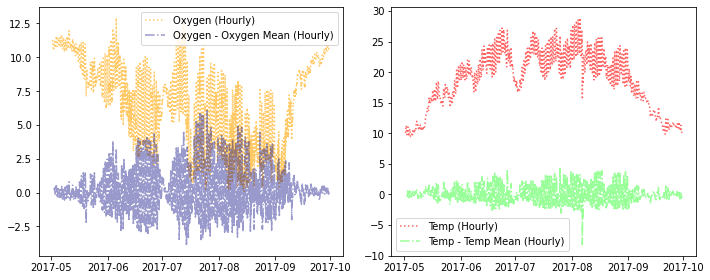

check min of difference series;  nan nan


In [14]:
print (len(resampled_oxygen1_h), len(simple_oxygen_mean_may_sept_h))

check_diff_oxygen_h = resampled_oxygen1_h - simple_oxygen_mean_may_sept_h
check_diff_oxygen_h_nonan = check_diff_oxygen_h.dropna()

check_diff_temp_h = resampled_temp1_h - simple_temp_mean_may_sept_h
check_diff_temp_h_nonan = check_diff_temp_h.dropna()

fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.plot(resampled_oxygen1_h, color='orange', linestyle=':', alpha=0.6, label='Oxygen (Hourly)')
plt.plot(check_diff_oxygen_h_nonan, color='navy', linestyle='-.', alpha=0.4, label='Oxygen - Oxygen Mean (Hourly)')
plt.legend(fontsize=10)

fig.add_subplot(122)
plt.plot(resampled_temp1_h, color='red', linestyle=':', alpha=0.6, label='Temp (Hourly)')
plt.plot(check_diff_temp_h_nonan, color='lime', linestyle='-.', alpha=0.4, label='Temp - Temp Mean (Hourly)')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print ('check min of difference series; ', min(check_diff_oxygen_h), min(check_diff_temp_h))

In [ ]:
print(np.isnan(check_diff_oxygen_h).sum())
print(np.isnan(resampled_oxygen1_30Minutes).sum())

23
0


7297
7250


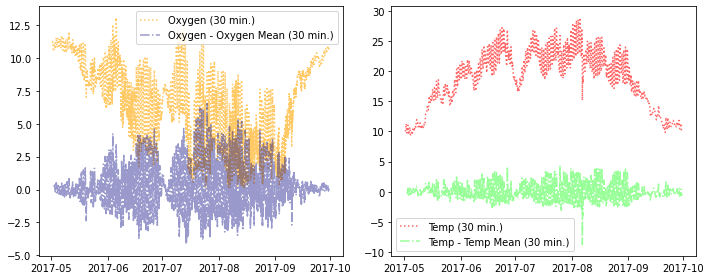

check min of difference series;  -4.172395833333334


In [15]:
check_diff_oxygen_30min = resampled_oxygen1_30Minutes - simple_oxygen_mean_may_sept_30min
check_diff_temp_30min = resampled_temp1_30Minutes - simple_temp_mean_may_sept_30min

print (len(check_diff_oxygen_30min))

check_diff_oxygen_30min_nonan = check_diff_oxygen_30min.dropna()
check_diff_temp_30min_nonan = check_diff_temp_30min.dropna()

print (len(check_diff_oxygen_30min_nonan))

fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.plot(resampled_oxygen1_30Minutes, color='orange', linestyle=':', alpha=0.6, label='Oxygen (30 min.)')
plt.plot(check_diff_oxygen_30min_nonan, color='navy', linestyle='-.', alpha=0.4, label='Oxygen - Oxygen Mean (30 min.)')
plt.legend(fontsize=10)

fig.add_subplot(122)
plt.plot(resampled_temp1_30Minutes, color='red', linestyle=':', alpha=0.6, label='Temp (30 min.)')
plt.plot(check_diff_temp_30min_nonan, color='lime', linestyle='-.', alpha=0.4, label='Temp - Temp Mean (30 min.)')
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

print ('check min of difference series; ', min(check_diff_oxygen_30min_nonan))

#### Check the ADF Test

Check the same adf test but now hopefully on a more stable data after subtracting the mean from the original data. 

In [16]:
cave_data_testADF_h_mean_Oxygen = adfuller(check_diff_oxygen_h_nonan, )
cave_data_testADF_h_mean_Temp = adfuller(check_diff_temp_h_nonan, )

#np.log2(m, out=np.zeros_like(m), where=(m!=0))

cavedfoutput_ADF_h_mean_Oxygen = pd.Series(cave_data_testADF_h_mean_Oxygen[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
cavedfoutput_ADF_h_mean_Temp = pd.Series(cave_data_testADF_h_mean_Temp[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print('for O2')
for key,value in cave_data_testADF_h_mean_Oxygen[4].items():
    cavedfoutput_ADF_h_mean_Oxygen['Critical Value (%s)'%key] = value
    
print(cavedfoutput_ADF_h_mean_Oxygen)

print('\n')
print('for Temp')
for key,value in cave_data_testADF_h_mean_Temp[4].items():
    cavedfoutput_ADF_h_mean_Temp['Critical Value (%s)'%key] = value

print(cavedfoutput_ADF_h_mean_Temp)    

for O2
Test Statistic                -1.138034e+01
p-value                        8.541894e-21
#Lags Used                     2.800000e+01
Number of Observations Used    3.597000e+03
Critical Value (1%)           -3.432169e+00
Critical Value (5%)           -2.862344e+00
Critical Value (10%)          -2.567198e+00
dtype: float64


for Temp
Test Statistic                -9.295716e+00
p-value                        1.147645e-15
#Lags Used                     3.000000e+01
Number of Observations Used    3.595000e+03
Critical Value (1%)           -3.432170e+00
Critical Value (5%)           -2.862344e+00
Critical Value (10%)          -2.567198e+00
dtype: float64


In [17]:
check_diff_oxygen_h_nonan_df = check_diff_oxygen_h_nonan.to_frame()
check_diff_temp_h_nonan_df = check_diff_temp_h_nonan.to_frame()

print(check_diff_oxygen_h_nonan_df.head(3))
print('\n')
print(check_diff_temp_h_nonan_df.head(3))

                       Oxygen
datetime                     
2017-05-02 14:00:00  0.156458
2017-05-02 15:00:00  0.227813
2017-05-02 16:00:00  0.285417


                         Temp
datetime                     
2017-05-02 14:00:00 -0.416667
2017-05-02 15:00:00 -0.252708
2017-05-02 16:00:00 -0.155417


In [18]:
oxy_temp_df_h_nonan_concat = pd.concat([check_diff_oxygen_h_nonan_df, check_diff_temp_h_nonan_df], axis=1)
print(oxy_temp_df_h_nonan_concat.head(3))

                       Oxygen      Temp
datetime                               
2017-05-02 14:00:00  0.156458 -0.416667
2017-05-02 15:00:00  0.227813 -0.252708
2017-05-02 16:00:00  0.285417 -0.155417


In [19]:


AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,10):
    model = VAR(endog=oxy_temp_df_h_nonan_concat)
    var_result = model.fit(maxlags=i)
    AIC[i] = var_result.aic
    print('all AICs: ', var_result.aic)


all AICs:  -3.540909690439903
all AICs:  -4.776951729952638
all AICs:  -4.780485561377479
all AICs:  -4.78965053135823
all AICs:  -4.792461421795413
all AICs:  -4.805706681026555
all AICs:  -4.8102595450487415
all AICs:  -4.8172912839846775
all AICs:  -4.836288594651376


In [20]:
check_diff_oxygen_30m_nonan_df = check_diff_oxygen_30min_nonan.to_frame()
check_diff_temp_30m_nonan_df = check_diff_temp_30min_nonan.to_frame()

oxy_temp_df_30m_nonan_concat = pd.concat([check_diff_oxygen_30m_nonan_df, check_diff_temp_30m_nonan_df], axis=1)
print(oxy_temp_df_30m_nonan_concat.head(3))

                       Oxygen      Temp
datetime                               
2017-05-02 14:30:00  0.176458 -0.361667
2017-05-02 15:00:00  0.208542 -0.294375
2017-05-02 15:30:00  0.245313 -0.207708


In [21]:
AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,10):
    model_30m = VAR(endog=oxy_temp_df_30m_nonan_concat)
    var_result = model_30m.fit(maxlags=i)
    AIC[i] = var_result.aic
    print('AICs: ', i, var_result.aic)

AICs:  1 -5.168583014613638
AICs:  2 -6.592476853459827
AICs:  3 -6.633686866651704
AICs:  4 -6.714484688177521
AICs:  5 -6.715322239794424
AICs:  6 -6.719211897470519
AICs:  7 -6.719428326354484
AICs:  8 -6.719012278021525
AICs:  9 -6.718427154816828


See a turnaround i.e. decrease in AIC from step 7 to 8, so we select order 7 for safety. 

In [22]:
def find_anomalies(squared_errors, z=1):
    threshold = np.mean(squared_errors) + (z*np.std(squared_errors)) # 1 std 
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

var = VAR(oxy_temp_df_30m_nonan_concat)
var_fitresults = var.fit(7)#selected lag =7
print(var_fitresults.resid.shape)

(7243, 2)


In [23]:
print(var_fitresults.resid[5:10])
print(var_fitresults.resid[5:10].sum(axis=0))
print(var_fitresults.resid[5:10].sum(axis=1))

squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors, z=2) # threshold = 7593.829254818655
print('check threshold: ', threshold)    

oxy_temp_30min_data_selected = oxy_temp_df_30m_nonan_concat.iloc[7:, :]
oxy_temp_30min_data_selected['Predictions'] = predictions.values
oxy_temp_30min_data_selected

                       Oxygen      Temp
datetime                               
2017-05-02 20:30:00 -0.002799  0.032251
2017-05-02 21:00:00 -0.027227 -0.013703
2017-05-02 21:30:00 -0.015526  0.028310
2017-05-02 22:00:00 -0.029360  0.012634
2017-05-02 22:30:00 -0.055553  0.024880
Oxygen   -0.130464
Temp      0.084373
dtype: float64
datetime
2017-05-02 20:30:00    0.029452
2017-05-02 21:00:00   -0.040929
2017-05-02 21:30:00    0.012784
2017-05-02 22:00:00   -0.016726
2017-05-02 22:30:00   -0.030673
Freq: 30T, dtype: float64
check threshold:  1.5053176393416041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Oxygen,Temp,Predictions
datetime,,,
2017-05-02 18:00:00,0.346354,-0.147917,0
2017-05-02 18:30:00,0.347708,-0.161042,0
2017-05-02 19:00:00,0.334063,-0.153333,0
2017-05-02 19:30:00,0.335104,-0.114792,0
2017-05-02 20:00:00,0.335625,-0.075417,0
...,...,...,...
2017-09-30 13:00:00,-0.007708,-0.534792,0
2017-09-30 13:30:00,0.023229,-0.497708,0
2017-09-30 14:00:00,0.044167,-0.450625,0


In [24]:
anomaly_var_points = oxy_temp_30min_data_selected.loc[oxy_temp_30min_data_selected['Predictions'] == 1]
anomaly_var_points_Oxygen_less_than_zero = anomaly_var_points.loc[anomaly_var_points['Oxygen']<=-0.01]
print(len(anomaly_var_points_Oxygen_less_than_zero))
anomaly_var_points_Oxygen_less_than_zero

42


,Oxygen,Temp,Predictions
datetime,,,
2017-06-09 05:00:00,-2.740521,-1.008958,1
2017-06-09 05:30:00,-0.297917,-1.078750,1
2017-06-09 13:00:00,-2.690521,0.213333,1
2017-06-13 13:00:00,-0.166667,-0.317292,1
2017-06-13 14:30:00,-0.571250,0.455208,1
2017-06-13 22:30:00,-0.999167,1.512500,1
2017-06-15 03:00:00,-2.366250,-1.322500,1
2017-06-18 04:00:00,-3.699479,-1.867292,1
2017-06-18 04:30:00,-1.925521,-1.972083,1


how many anomalies:  0    7091
1     152
Name: Predictions, dtype: int64


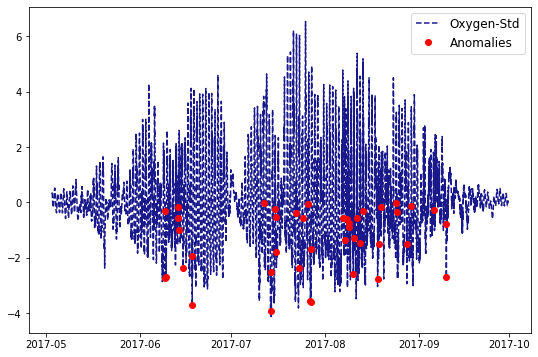

In [25]:
print('how many anomalies: ', oxy_temp_30min_data_selected['Predictions'].value_counts())


fig = plt.figure(figsize=(9, 6))
plt.plot(oxy_temp_30min_data_selected.Oxygen, color='navy', linestyle='--', alpha=0.9, label='Oxygen-Std')
plt.plot(anomaly_var_points_Oxygen_less_than_zero.Oxygen, color='red', linestyle='None', marker='o', label='Anomalies')
plt.legend(fontsize=12, loc=1)
plt.show()

In [26]:
def f(row):
    if (row['Predictions'] == 1) & (row['Oxygen']<=-0.01):
        val = 1
    else:
        val = 0
    return val

oxy_temp_30min_data_selected['Anomaly'] = oxy_temp_30min_data_selected.apply(f, axis=1)
print(oxy_temp_30min_data_selected.head(3))

                       Oxygen      Temp  Predictions  Anomaly
datetime                                                     
2017-05-02 18:00:00  0.346354 -0.147917            0        0
2017-05-02 18:30:00  0.347708 -0.161042            0        0
2017-05-02 19:00:00  0.334063 -0.153333            0        0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
oxy_temp_30min_data_selected['Anomaly'].value_counts()

0    7201
1      42
Name: Anomaly, dtype: int64

In [28]:
oxy_temp_30min_data_selected['FinalAnomaly'] = np.where(oxy_temp_30min_data_selected['Anomaly']==1 , oxy_temp_30min_data_selected['Oxygen'], np.nan)
oxy_temp_30min_data_selected

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Oxygen,Temp,Predictions,Anomaly,FinalAnomaly
datetime,,,,,
2017-05-02 18:00:00,0.346354,-0.147917,0,0,NaN
2017-05-02 18:30:00,0.347708,-0.161042,0,0,NaN
2017-05-02 19:00:00,0.334063,-0.153333,0,0,NaN
2017-05-02 19:30:00,0.335104,-0.114792,0,0,NaN
2017-05-02 20:00:00,0.335625,-0.075417,0,0,NaN
...,...,...,...,...,...
2017-09-30 13:00:00,-0.007708,-0.534792,0,0,NaN
2017-09-30 13:30:00,0.023229,-0.497708,0,0,NaN
2017-09-30 14:00:00,0.044167,-0.450625,0,0,NaN


In [29]:
oxy_temp_30min_data_selected['Predictions'].value_counts()

0    7091
1     152
Name: Predictions, dtype: int64

In [30]:
print (len(oxy_temp_30min_data_selected.Oxygen), len(simple_oxygen_mean_may_sept_30min))

7243 7297


In [31]:
print (simple_oxygen_mean_may_sept_30min.isna().sum())
simple_oxygen_mean_may_sept_30min_nonan = simple_oxygen_mean_may_sept_30min.dropna()
simple_oxygen_mean_may_sept_30min_nonan_selected = simple_oxygen_mean_may_sept_30min_nonan.iloc[7:,]
simple_oxygen_mean_may_sept_30min_nonan_selected

47


datetime
2017-05-02 18:00:00    10.818646
2017-05-02 18:30:00    10.817292
2017-05-02 19:00:00    10.815937
2017-05-02 19:30:00    10.814896
2017-05-02 20:00:00    10.814375
                         ...    
2017-09-30 13:00:00    10.752708
2017-09-30 13:30:00    10.756771
2017-09-30 14:00:00    10.760833
2017-09-30 14:30:00    10.764479
2017-09-30 15:00:00    10.768125
Freq: 30T, Name: Oxygen, Length: 7243, dtype: float64

In [32]:
oxy_temp_30min_data_selected['Mean_Oxy'] = simple_oxygen_mean_may_sept_30min_nonan_selected
oxy_temp_30min_data_selected['TotOxy'] = oxy_temp_30min_data_selected['Mean_Oxy'] + oxy_temp_30min_data_selected['Oxygen']
oxy_temp_30min_data_selected.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Oxygen,Temp,Predictions,Anomaly,FinalAnomaly,Mean_Oxy,TotOxy
datetime,,,,,,,
2017-05-02 18:00:00,0.346354,-0.147917,0,0,NaN,10.818646,11.165
2017-05-02 18:30:00,0.347708,-0.161042,0,0,NaN,10.817292,11.165
2017-05-02 19:00:00,0.334063,-0.153333,0,0,NaN,10.815937,11.150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


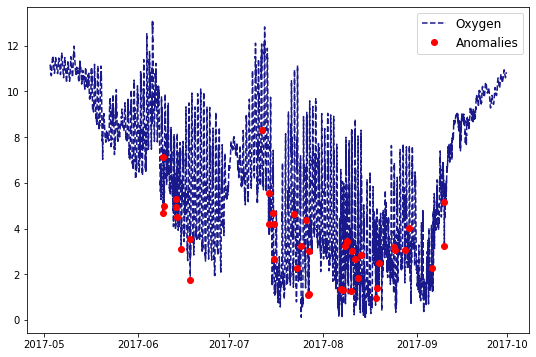

In [33]:
oxy_temp_30min_data_selected['FinalAnomaly1'] = oxy_temp_30min_data_selected['FinalAnomaly'] + simple_oxygen_mean_may_sept_30min_nonan_selected

fig = plt.figure(figsize=(9, 6))
plt.plot(oxy_temp_30min_data_selected.TotOxy, color='navy', linestyle='--', alpha=0.9, label='Oxygen')
plt.plot(oxy_temp_30min_data_selected.FinalAnomaly1, color='red', linestyle='None', marker='o', label='Anomalies')
plt.legend(fontsize=12, loc=1)
plt.show()

In [34]:
resampled_oxygen1_30Minutes_an = oxy_temp_30min_data_selected["TotOxy"].resample("720T").mean() # 
resampled_30Minutes_anomaly = oxy_temp_30min_data_selected["FinalAnomaly1"].resample("5D").mean() # 30 minutes

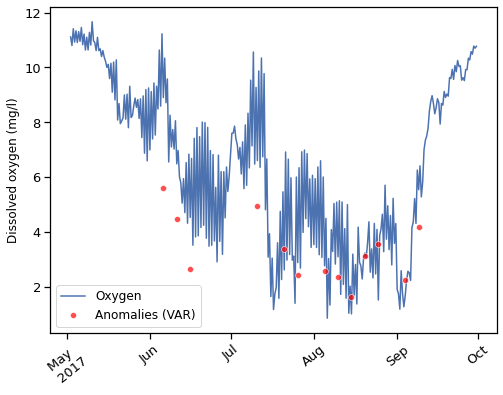

[736450. 736481. 736511. 736542. 736573. 736603.]


In [35]:
sns.set_theme(style={'axes.facecolor': 'white', 'ytick.left': True, 'xtick.bottom': True,}, 
              font_scale=1.1, )

get_xticks = [736450., 736481., 736511., 736542., 736573., 736603.]
get_xlabels = ['May \n 2017', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

fig = plt.figure(figsize=(8, 6))
lin = sns.lineplot(data = resampled_oxygen1_30Minutes_an, label='Oxygen')
lin = sns.lineplot(data = resampled_30Minutes_anomaly, marker='o', linestyle='', color = 'red', 
                   alpha=0.7, label='Anomalies (VAR)')
plt.ylabel('Dissolved oxygen (mg/l)', fontsize=12)
plt.xlabel('')

plt.xticks(get_xticks, get_xlabels, fontsize=13, rotation=39)
plt.yticks(fontsize=13)
plt.show()

print (lin.get_xticks())

##  2021 Data

In [36]:
path_to_file = '/content/drive/My Drive/Colab Notebooks/Cave_Data/'

data_csv_2021 = pd.read_csv(path_to_file + 'OxygenandTemp_2021.csv', sep=',', parse_dates=[['Date', 'Time']])
data_csv_2021.head(3)

,Date_Time,DO (mg/L),Temp (°C)
0,2021-03-08 11:00:00,14.42,5.32
1,2021-03-08 11:15:00,14.47,5.40
2,2021-03-08 11:30:00,14.58,5.48


In [37]:
cave_data2021 = data_csv_2021.rename({'Date_Time': 'datetime' ,'DO (mg/L)': 'Oxygen', 'Temp (°C)': 'Temp'}, axis=1)

cave_data2021['datetime'] = pd.to_datetime(cave_data2021['datetime'])
cave_data2021 = cave_data2021.set_index('datetime') 

print(cave_data2021.head(5))
print ('\n')
print ('cave data shape: ', cave_data2021.shape)

                     Oxygen  Temp
datetime                         
2021-03-08 11:00:00   14.42  5.32
2021-03-08 11:15:00   14.47  5.40
2021-03-08 11:30:00   14.58  5.48
2021-03-08 11:45:00   14.65  5.54
2021-03-08 12:00:00   14.61  5.62


cave data shape:  (19967, 2)


In [ ]:
cave_data2021.index.max()

Timestamp('2021-10-02 10:30:00')

select dataframe shape:  (14497, 2)


Text(0.5, 0, 'Date-Time')

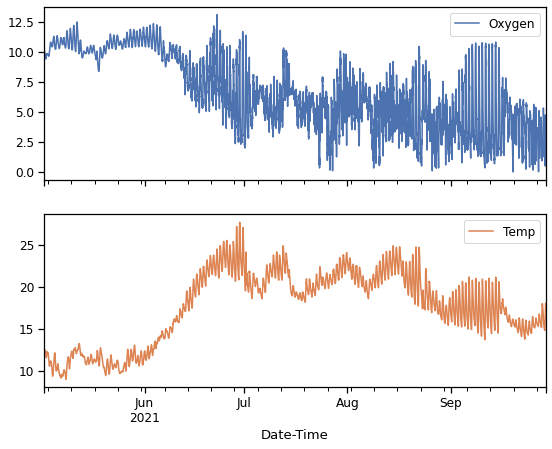

In [38]:
cave_data2021_may_sept = cave_data2021["2021-05-01 15:00:00": "2021-09-29 15:00:00"]
print ('select dataframe shape: ', cave_data2021_may_sept.shape)

fig, ax = cave_data2021_may_sept.plot(subplots=True, figsize=(9, 7))
ax.set_xlabel('Date-Time')

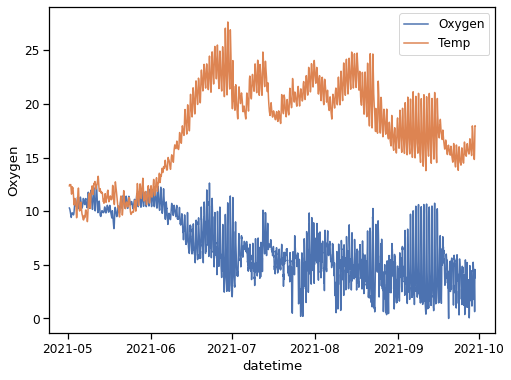

total samples of daily data:  3625


In [39]:
resampled_oxygen2021_h = cave_data2021_may_sept["Oxygen"].resample("60T").mean() # hourly samples
resampled_temp2021_h = cave_data2021_may_sept["Temp"].resample("60T").mean() # hourly samples

fig = plt.figure(figsize=(8, 6))
sns.lineplot(data = resampled_oxygen2021_h, label='Oxygen')
sns.lineplot(data = resampled_temp2021_h, label='Temp')
plt.show()

print ('total samples of daily data: ', len(resampled_oxygen2021_h))

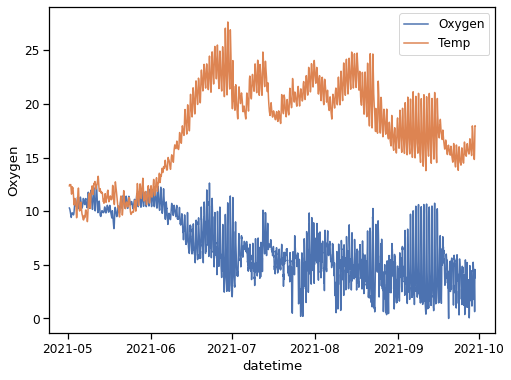

total samples of daily data:  7249


In [40]:
resampled_oxygen2021_30min = cave_data2021_may_sept["Oxygen"].resample("30T").mean() # hourly samples
resampled_temp2021_30min = cave_data2021_may_sept["Temp"].resample("30T").mean() # hourly samples

fig = plt.figure(figsize=(8, 6))
sns.lineplot(data = resampled_oxygen2021_h, label='Oxygen')
sns.lineplot(data = resampled_temp2021_h, label='Temp')
plt.show()

print ('total samples of daily data: ', len(resampled_oxygen2021_30min))

In [41]:
from statsmodels.tsa.stattools import adfuller

cave_data_testADF_30m_2021 = adfuller(resampled_oxygen2021_30min, )
cave_data_testADF_30m_2021_temp = adfuller(resampled_temp2021_30min, )

#np.log2(m, out=np.zeros_like(m), where=(m!=0))

cavedfoutput_ADF_30m_2021 = pd.Series(cave_data_testADF_30m_2021[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
cavedfoutput_ADF_30m_2021_temp = pd.Series(cave_data_testADF_30m_2021_temp[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print('for O2')
for key, value in cave_data_testADF_30m_2021[4].items():
    cavedfoutput_ADF_30m_2021['Critical Value (%s)'%key] = value
    
print(cavedfoutput_ADF_30m_2021)

print('\n')
for key, value in cave_data_testADF_30m_2021_temp[4].items():
    cavedfoutput_ADF_30m_2021_temp['Critical Value (%s)'%key] = value
    
print(cavedfoutput_ADF_30m_2021_temp)

for O2
Test Statistic                   -2.670299
p-value                           0.079320
#Lags Used                       36.000000
Number of Observations Used    7212.000000
Critical Value (1%)              -3.431257
Critical Value (5%)              -2.861941
Critical Value (10%)             -2.566983
dtype: float64


Test Statistic                   -1.280934
p-value                           0.637849
#Lags Used                       36.000000
Number of Observations Used    7212.000000
Critical Value (1%)              -3.431257
Critical Value (5%)              -2.861941
Critical Value (10%)             -2.566983
dtype: float64


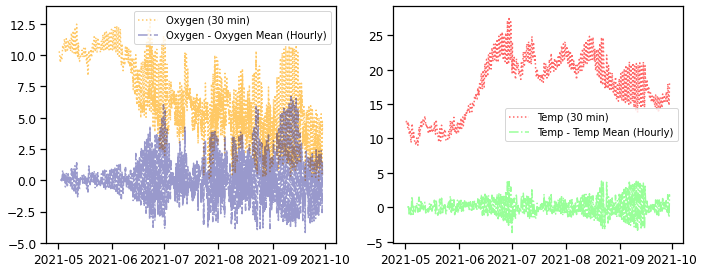

check min of difference series;  -4.174375


In [42]:
simple_oxygen_mean_may_sept_30min_2021 = resampled_oxygen2021_30min.rolling(window=48).mean()
simple_temp_mean_may_sept_30min_2021 = resampled_temp2021_30min.rolling(window=48).mean()

check_diff_oxygen_30min_2021 = resampled_oxygen2021_30min - simple_oxygen_mean_may_sept_30min_2021
check_diff_temp_30min_2021 = resampled_temp2021_30min - simple_temp_mean_may_sept_30min_2021

check_diff_oxygen_30min_2021_nonan = check_diff_oxygen_30min_2021.dropna()
check_diff_temp_30min_2021_nonan = check_diff_temp_30min_2021.dropna()

fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.plot(resampled_oxygen2021_30min, color='orange', linestyle=':', alpha=0.6, label='Oxygen (30 min)')
plt.plot(check_diff_oxygen_30min_2021_nonan, color='navy', linestyle='-.', alpha=0.4, label='Oxygen - Oxygen Mean (Hourly)')
plt.legend(fontsize=10)

fig.add_subplot(122)
plt.plot(resampled_temp2021_30min, color='red', linestyle=':', alpha=0.6, label='Temp (30 min)')
plt.plot(check_diff_temp_30min_2021_nonan, color='lime', linestyle='-.', alpha=0.4, label='Temp - Temp Mean (Hourly)')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print ('check min of difference series; ', min(check_diff_oxygen_30min_2021_nonan))

#### Confirm again with AdFuller Test

In [43]:
cave_data2021_testADF_30m_mean_Oxygen = adfuller(check_diff_oxygen_30min_2021_nonan, )
cave_data2021_testADF_30m_mean_Temp = adfuller(check_diff_temp_30min_2021_nonan, )

#np.log2(m, out=np.zeros_like(m), where=(m!=0))

cavedfoutput_ADF_30min_mean_Oxygen_2021 = pd.Series(cave_data2021_testADF_30m_mean_Oxygen[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
cavedfoutput_ADF_30min_mean_Temp_2021 = pd.Series(cave_data2021_testADF_30m_mean_Temp[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print('for O2')
for key, value in cave_data2021_testADF_30m_mean_Oxygen[4].items():
    cavedfoutput_ADF_30min_mean_Oxygen_2021['Critical Value (%s)'%key] = value
    
print(cavedfoutput_ADF_30min_mean_Oxygen_2021)

print('\n')
print('for Temp')
for key, value in cave_data2021_testADF_30m_mean_Temp[4].items():
    cavedfoutput_ADF_30min_mean_Temp_2021['Critical Value (%s)'%key] = value

print(cavedfoutput_ADF_30min_mean_Temp_2021)    

for O2
Test Statistic                  -18.977814
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    7166.000000
Critical Value (1%)              -3.431263
Critical Value (5%)              -2.861943
Critical Value (10%)             -2.566985
dtype: float64


for Temp
Test Statistic                -8.882322e+00
p-value                        1.307830e-14
#Lags Used                     3.500000e+01
Number of Observations Used    7.166000e+03
Critical Value (1%)           -3.431263e+00
Critical Value (5%)           -2.861943e+00
Critical Value (10%)          -2.566985e+00
dtype: float64


In [44]:
check_diff_oxygen_30min_2021_nonan_df = check_diff_oxygen_30min_2021_nonan.to_frame()
check_diff_temp_30min_2021_nonan_df = check_diff_temp_30min_2021_nonan.to_frame()

print(check_diff_oxygen_30min_2021_nonan_df.head(3))
print('\n')
print(check_diff_temp_30min_2021_nonan_df.head(3))

                       Oxygen
datetime                     
2021-05-02 14:30:00 -0.034271
2021-05-02 15:00:00 -0.028854
2021-05-02 15:30:00 -0.013958


                         Temp
datetime                     
2021-05-02 14:30:00  0.046875
2021-05-02 15:00:00  0.077917
2021-05-02 15:30:00  0.080208


In [45]:
oxy_temp_df_30m_nonan_concat_2021 = pd.concat([check_diff_oxygen_30min_2021_nonan_df, check_diff_temp_30min_2021_nonan_df], axis=1)
print(oxy_temp_df_30m_nonan_concat_2021.head(3))

                       Oxygen      Temp
datetime                               
2021-05-02 14:30:00 -0.034271  0.046875
2021-05-02 15:00:00 -0.028854  0.077917
2021-05-02 15:30:00 -0.013958  0.080208


In [46]:
AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1, 30):
    model_30m_2021 = VAR(endog=oxy_temp_df_30m_nonan_concat_2021)
    var_result_2021 = model_30m_2021.fit(maxlags=i)
    AIC[i] = var_result_2021.aic
    print('AICs: ', i, var_result_2021.aic)
  

AICs:  1 -5.237597322354886
AICs:  2 -6.894477400923195
AICs:  3 -6.909358464343682
AICs:  4 -6.926789001723222
AICs:  5 -6.928546716673973
AICs:  6 -6.933014061326117
AICs:  7 -6.93432301081463
AICs:  8 -6.940092698297466
AICs:  9 -6.944782263038404
AICs:  10 -6.94690318210094
AICs:  11 -6.951457662544224
AICs:  12 -6.9540937395395055
AICs:  13 -6.956464754209812
AICs:  14 -6.95933835797265
AICs:  15 -6.959596040051822
AICs:  16 -6.959283700033594
AICs:  17 -6.960975575906382
AICs:  18 -6.965056761595869
AICs:  19 -6.969561700590758
AICs:  20 -6.972873985947425
AICs:  21 -6.973974984104949
AICs:  22 -6.975631104227906
AICs:  23 -6.974987010806799
AICs:  24 -6.975587837700302
AICs:  25 -6.976094986922503
AICs:  26 -6.97701939712229
AICs:  27 -6.97830276987782
AICs:  28 -6.979697937748074
AICs:  29 -6.983284492661234


In [47]:
def find_anomalies(squared_errors, z=1):
    threshold = np.mean(squared_errors) + (z*np.std(squared_errors)) # 1 std 
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

var2021 = VAR(oxy_temp_df_30m_nonan_concat_2021)
var2021_fitresults = var2021.fit(7) #selected lag =7
print(var2021_fitresults.resid.shape)

(7195, 2)


In [48]:
print(var2021_fitresults.resid[5:10])
print(var2021_fitresults.resid[5:10].sum(axis=0))
print(var2021_fitresults.resid[5:10].sum(axis=1))

squared_errors2021 = var2021_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors2021, z=2) # threshold = 7593.829254818655
print('check threshold: ', threshold)    

oxy_temp_30min_data_selected_2021 = oxy_temp_df_30m_nonan_concat_2021.iloc[7:, :]
oxy_temp_30min_data_selected_2021['Predictions'] = predictions.values
oxy_temp_30min_data_selected_2021

                       Oxygen      Temp
datetime                               
2021-05-02 20:30:00 -0.009588  0.007735
2021-05-02 21:00:00 -0.028637  0.004643
2021-05-02 21:30:00 -0.043223 -0.018155
2021-05-02 22:00:00  0.001115 -0.002532
2021-05-02 22:30:00 -0.009928 -0.001001
Oxygen   -0.090261
Temp     -0.009311
dtype: float64
datetime
2021-05-02 20:30:00   -0.001853
2021-05-02 21:00:00   -0.023994
2021-05-02 21:30:00   -0.061378
2021-05-02 22:00:00   -0.001418
2021-05-02 22:30:00   -0.010929
Freq: 30T, dtype: float64
check threshold:  1.6422788947948959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Oxygen,Temp,Predictions
datetime,,,
2021-05-02 18:00:00,0.028229,0.022292,0
2021-05-02 18:30:00,0.037083,-0.001250,0
2021-05-02 19:00:00,0.055417,-0.024583,0
2021-05-02 19:30:00,0.068021,-0.018125,0
2021-05-02 20:00:00,0.070208,0.007708,0
...,...,...,...
2021-09-29 13:00:00,1.432812,1.659792,0
2021-09-29 13:30:00,1.102292,1.808333,0
2021-09-29 14:00:00,0.562500,1.787292,0


In [49]:
anomaly_var_points_2021 = oxy_temp_30min_data_selected_2021.loc[oxy_temp_30min_data_selected_2021['Predictions'] == 1]
anomaly_var_points_Oxygen_less_than_zero_2021 = anomaly_var_points_2021.loc[anomaly_var_points_2021['Oxygen']<=-0.01]
print(len(anomaly_var_points_Oxygen_less_than_zero_2021))
anomaly_var_points_Oxygen_less_than_zero_2021

30


,Oxygen,Temp,Predictions
datetime,,,
2021-06-23 12:30:00,-0.475729,0.140417,1
2021-06-24 11:30:00,-3.691979,-0.296875,1
2021-06-25 11:30:00,-1.605729,-0.317708,1
2021-06-25 12:30:00,-3.153854,0.251458,1
2021-06-28 10:30:00,-0.169167,-0.627500,1
2021-07-11 13:30:00,-1.767187,1.275208,1
2021-07-23 19:00:00,-0.314687,1.433750,1
2021-07-28 18:00:00,-0.713750,1.209583,1
2021-07-29 11:00:00,-0.301458,-0.413958,1


how many anomalies:  0    7038
1     157
Name: Predictions, dtype: int64


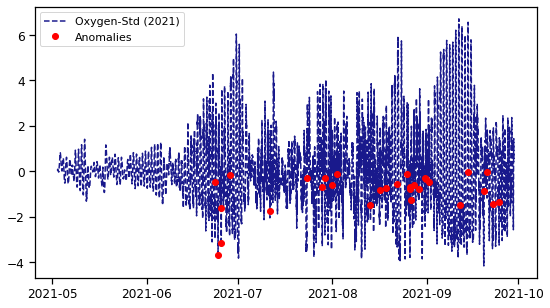

In [50]:
print('how many anomalies: ', oxy_temp_30min_data_selected_2021['Predictions'].value_counts())


fig = plt.figure(figsize=(9, 5))
plt.plot(oxy_temp_30min_data_selected_2021.Oxygen, color='navy', linestyle='--', alpha=0.9, label='Oxygen-Std (2021)')
plt.plot(anomaly_var_points_Oxygen_less_than_zero_2021.Oxygen, color='red', linestyle='None', marker='o', label='Anomalies')
plt.legend(fontsize=11,)
plt.show()

In [51]:
def f(row):
    if (row['Predictions'] == 1) & (row['Oxygen']<=-0.01):
        val = 1
    else:
        val = 0
    return val

oxy_temp_30min_data_selected_2021['Anomaly'] = oxy_temp_30min_data_selected_2021.apply(f, axis=1)
print(oxy_temp_30min_data_selected_2021.head(3))    

                       Oxygen      Temp  Predictions  Anomaly
datetime                                                     
2021-05-02 18:00:00  0.028229  0.022292            0        0
2021-05-02 18:30:00  0.037083 -0.001250            0        0
2021-05-02 19:00:00  0.055417 -0.024583            0        0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
oxy_temp_30min_data_selected_2021['FinalAnomaly'] = np.where(oxy_temp_30min_data_selected_2021['Anomaly']==1 , oxy_temp_30min_data_selected_2021['Oxygen'], np.nan)
oxy_temp_30min_data_selected_2021

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Oxygen,Temp,Predictions,Anomaly,FinalAnomaly
datetime,,,,,
2021-05-02 18:00:00,0.028229,0.022292,0,0,NaN
2021-05-02 18:30:00,0.037083,-0.001250,0,0,NaN
2021-05-02 19:00:00,0.055417,-0.024583,0,0,NaN
2021-05-02 19:30:00,0.068021,-0.018125,0,0,NaN
2021-05-02 20:00:00,0.070208,0.007708,0,0,NaN
...,...,...,...,...,...
2021-09-29 13:00:00,1.432812,1.659792,0,0,NaN
2021-09-29 13:30:00,1.102292,1.808333,0,0,NaN
2021-09-29 14:00:00,0.562500,1.787292,0,0,NaN


In [53]:
print (simple_oxygen_mean_may_sept_30min_2021.isna().sum())
simple_oxygen_mean_may_sept_30min_nonan_2021 = simple_oxygen_mean_may_sept_30min_2021.dropna()
simple_oxygen_mean_may_sept_30min_nonan_selected_2021 = simple_oxygen_mean_may_sept_30min_nonan_2021.iloc[7:,]
simple_oxygen_mean_may_sept_30min_nonan_selected_2021

47


datetime
2021-05-02 18:00:00    9.776771
2021-05-02 18:30:00    9.767917
2021-05-02 19:00:00    9.759583
2021-05-02 19:30:00    9.751979
2021-05-02 20:00:00    9.744792
                         ...   
2021-09-29 13:00:00    3.282188
2021-09-29 13:30:00    3.312708
2021-09-29 14:00:00    3.342500
2021-09-29 14:30:00    3.374479
2021-09-29 15:00:00    3.407396
Freq: 30T, Name: Oxygen, Length: 7195, dtype: float64

In [54]:
oxy_temp_30min_data_selected_2021['Mean_Oxy'] = simple_oxygen_mean_may_sept_30min_nonan_selected_2021
oxy_temp_30min_data_selected_2021['TotOxy'] = oxy_temp_30min_data_selected_2021['Mean_Oxy'] + oxy_temp_30min_data_selected_2021['Oxygen']
oxy_temp_30min_data_selected_2021.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Oxygen,Temp,Predictions,Anomaly,FinalAnomaly,Mean_Oxy,TotOxy
datetime,,,,,,,
2021-05-02 18:00:00,0.028229,0.022292,0,0,NaN,9.776771,9.805
2021-05-02 18:30:00,0.037083,-0.001250,0,0,NaN,9.767917,9.805
2021-05-02 19:00:00,0.055417,-0.024583,0,0,NaN,9.759583,9.815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


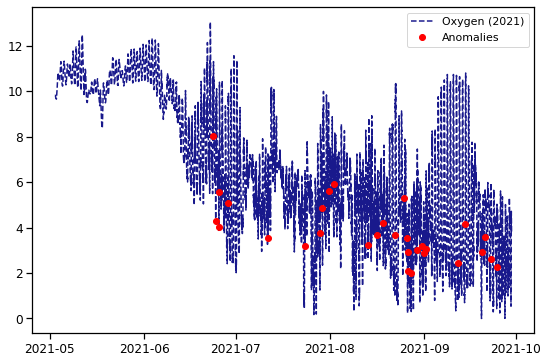

In [55]:
oxy_temp_30min_data_selected_2021['FinalAnomaly1'] = oxy_temp_30min_data_selected_2021['FinalAnomaly'] + simple_oxygen_mean_may_sept_30min_nonan_selected_2021

fig = plt.figure(figsize=(9, 6))
plt.plot(oxy_temp_30min_data_selected_2021.TotOxy, color='navy', linestyle='--', alpha=0.9, label='Oxygen (2021)')
plt.plot(oxy_temp_30min_data_selected_2021.FinalAnomaly1, color='red', linestyle='None', marker='o', label='Anomalies')
plt.legend(fontsize=11, loc=1)
plt.show()

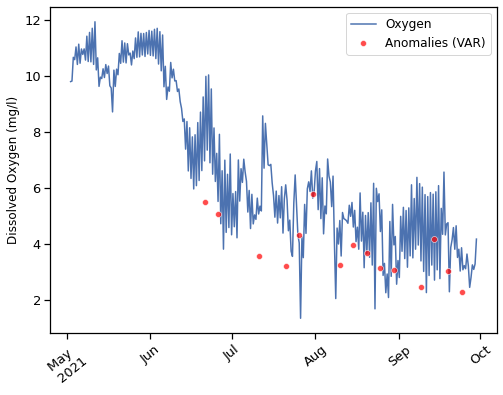

[737911. 737942. 737972. 738003. 738034. 738064.]


In [56]:
resampled_oxygen1_30Minutes_an_2021 = oxy_temp_30min_data_selected_2021["TotOxy"].resample("720T").mean() # 
resampled_30Minutes_anomaly_2021 = oxy_temp_30min_data_selected_2021["FinalAnomaly1"].resample("5D").mean() # 30 minutes

get_xticks_2021 = [737911., 737942., 737972., 738003., 738034., 738064.]
get_xlabel = ['May \n 2021', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']


fig = plt.figure(figsize=(8, 6))
lin = sns.lineplot(data = resampled_oxygen1_30Minutes_an_2021, label='Oxygen')
lin = sns.lineplot(data = resampled_30Minutes_anomaly_2021, marker='o', color = 'red', 
                   alpha=0.7, linestyle='', label='Anomalies (VAR)')
plt.ylabel('Dissolved Oxygen (mg/l)', fontsize=12)
plt.yticks(fontsize=13)
plt.xticks(get_xticks_2021, get_xlabel, fontsize=13, rotation=39)
plt.xlabel('')
plt.show()

print (lin.get_xticks())

------------------------------------------------